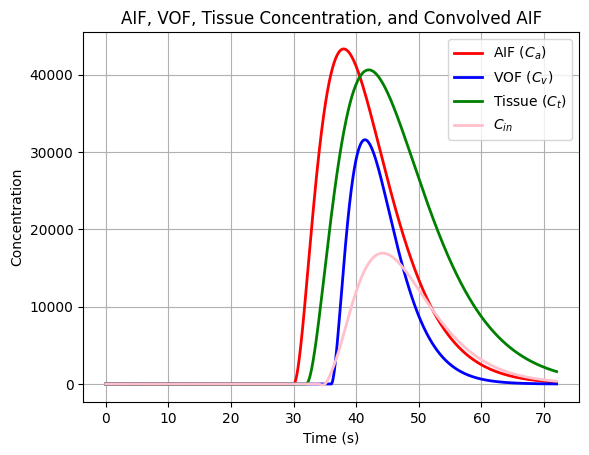

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import gamma
from scipy.interpolate import interp1d

# Define the Gamma-Variate function
def gamma_variate(t, A, t0, alpha, beta):
    return A * (t - t0)**alpha * np.exp(-(t - t0)/beta) * (t > t0)

# Define Ca, Cv, and Ct using the Gamma-Variate function
def Ca(t):
    return gamma_variate(t, 5000, 30, 2, 4)

def Cv(t):
    return gamma_variate(t, 8000, 36, 2, 2.7)

def Ct(t):
    return gamma_variate(t, 3000, 32, 2, 5)

# Define the gamma distribution as the residue function R(t)
def gamma_distribution(t, t1, k, theta):
    if t >= t1:
        return (1 / (gamma(k) * theta**k)) * (t - t1)**(k - 1) * np.exp(-(t - t1) / theta)
    else:
        return 0

# Define the residue function R(t)
def R(t, t1, k1, sigma1):
    return gamma_distribution(t, t1, k1, sigma1)

# Precompute convolution values
time_grid = np.arange(0, 73, 1)
Ca_integral = quad(Ca, 0, 72)[0]
Cv_integral = quad(Cv, 0, 72)[0]
kappa = Ca_integral / Cv_integral

# Set parameters
t1 = 4
k1 = 1
sigma1 = 2
HLV = 0.45
HSV = 0.35

# Calculate convolution and interpolation
Cin_values = []
for t in time_grid:
    integral_value = quad(lambda tau: Ca(tau) * R(t - tau, t1, k1, sigma1), 0, t)[0]
    Cin_values.append((1 / kappa) * ((1 - HLV) / (1 - HSV)) * integral_value)

Cin_interp = interp1d(time_grid, Cin_values, kind='cubic', fill_value="extrapolate")

# Plotting
t_vals = np.linspace(0, 72, 1000)
plt.plot(t_vals, Ca(t_vals), label=r'AIF ($C_a$)', color='red', linewidth=2)
plt.plot(t_vals, Cv(t_vals), label=r'VOF ($C_v$)', color='blue', linewidth=2)
plt.plot(t_vals, Ct(t_vals), label=r'Tissue ($C_t$)', color='green', linewidth=2)
plt.plot(t_vals, Cin_interp(t_vals), label=r'$C_{in}$', color='pink', linewidth=2)

plt.xlabel('Time (s)')
plt.ylabel('Concentration')
plt.title('AIF, VOF, Tissue Concentration, and Convolved AIF')
plt.legend()
plt.grid(True)
plt.show()

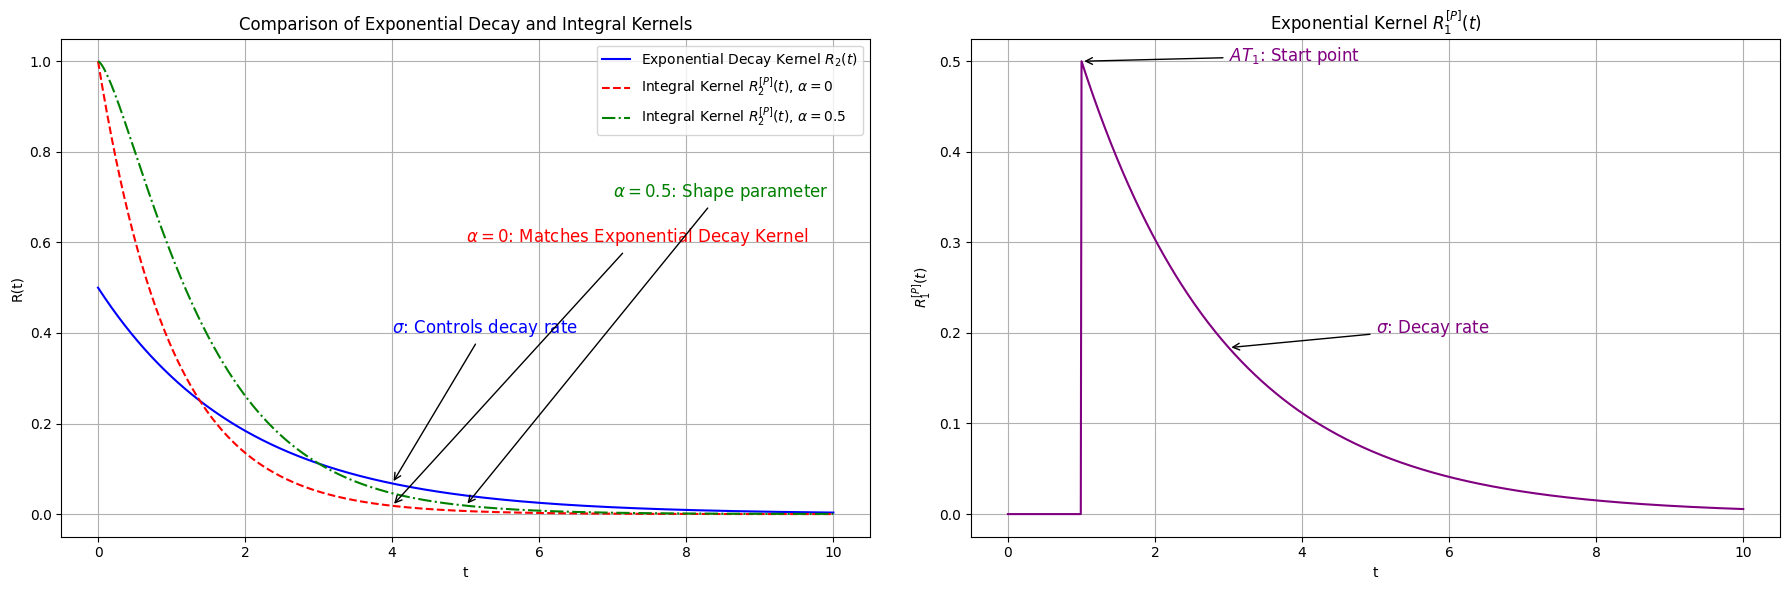

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma

# Define the time range
t = np.linspace(0, 10, 1000)

# Define common parameter sigma
sigma = 2

# Kernel 1: Exponential Decay Kernel R2(t)
R2 = (1/sigma) * np.exp(-t/sigma)

# Kernel 2: Exponential Kernel with Shift R1^(P)(t)
AT1 = 1
R1P = np.where(t >= AT1, (1/sigma) * np.exp(-(t - AT1)/sigma), 0)

# Integral Kernel R2^(P)(t) with alpha = 0 (should match Exponential Decay Kernel)
def integral_kernel(t, sigma, alpha):
    tau = np.linspace(0, t, 1000)
    integrand = (tau**alpha / (gamma(1 + alpha) * sigma**(1 + alpha))) * np.exp(-tau/sigma)
    integral = 1 - np.trapz(integrand, tau)
    return integral

R2P_alpha_0 = np.array([integral_kernel(ti, sigma=1, alpha=0) for ti in t])
R2P_alpha_nonzero = np.array([integral_kernel(ti, sigma=1, alpha=0.5) for ti in t])

# Create the plots
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Plot Kernel 1: Exponential Decay and Integral Kernels with two different alphas
ax[0].plot(t, R2, color='blue', label=r'Exponential Decay Kernel $R_2(t)$')
ax[0].plot(t, R2P_alpha_0, color='red', linestyle='--', label=r'Integral Kernel $R_2^{[P]}(t)$, $\alpha=0$')
ax[0].plot(t, R2P_alpha_nonzero, color='green', linestyle='-.', label=r'Integral Kernel $R_2^{[P]}(t)$, $\alpha=0.5$')
ax[0].set_title('Comparison of Exponential Decay and Integral Kernels')
ax[0].set_xlabel('t')
ax[0].set_ylabel('R(t)')
ax[0].legend()
ax[0].grid(True)

# Annotate Exponential Decay Kernel (R2)
ax[0].annotate(r'$\sigma$: Controls decay rate',
               xy=(2 * sigma, R2[int(2 * sigma * 100)]), xycoords='data',
               xytext=(4, 0.4), textcoords='data',
               arrowprops=dict(facecolor='black', arrowstyle="->"),
               fontsize=12, color='blue')

# Annotate Integral Kernel with alpha = 0
ax[0].annotate(r'$\alpha = 0$: Matches Exponential Decay Kernel',
               xy=(2 * sigma, R2P_alpha_0[int(2 * sigma * 100)]), xycoords='data',
               xytext=(5, 0.6), textcoords='data',
               arrowprops=dict(facecolor='black', arrowstyle="->"),
               fontsize=12, color='red')

# Annotate Integral Kernel with alpha = 0.5
ax[0].annotate(r'$\alpha = 0.5$: Shape parameter',
               xy=(5, R2P_alpha_nonzero[int(5 * 100)]), xycoords='data',
               xytext=(7, 0.7), textcoords='data',
               arrowprops=dict(facecolor='black', arrowstyle="->"),
               fontsize=12, color='green')

# Plot Kernel 2: Exponential with Shift
ax[1].plot(t, R1P, color='purple', label='Exponential Kernel $R_1^{[P]}(t)$')
ax[1].set_title('Exponential Kernel $R_1^{[P]}(t)$')
ax[1].set_xlabel('t')
ax[1].set_ylabel('$R_1^{[P]}(t)$')
ax[1].grid(True)

# Annotate Exponential Kernel (R1P)
ax[1].annotate(r'$AT_1$: Start point',
               xy=(AT1, R1P[int(AT1 * 100)]), xycoords='data',
               xytext=(3, 0.5), textcoords='data',
               arrowprops=dict(facecolor='black', arrowstyle="->"),
               fontsize=12, color='purple')
ax[1].annotate(r'$\sigma$: Decay rate',
               xy=(2 + AT1, R1P[int((2 + AT1) * 100)]), xycoords='data',
               xytext=(5, 0.2), textcoords='data',
               arrowprops=dict(facecolor='black', arrowstyle="->"),
               fontsize=12, color='purple')

# Adjust layout and show
plt.tight_layout()
plt.show()